In [ ]:
import torch
from torch.utils.data import DataLoader
from data.CK_plus import CK_plus
from data.AffectNet import AffectNetDataset
from torchvision import transforms as tf
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

/Users/nikolairoehrich/repos/AI_Practical/CVDL_Practical/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = torch.load('/Users/nikolairoehrich/repos/AI_Practical/CVDL_Practical/training/affectnet_10epochs_hybrid.pth', map_location=torch.device('cpu'))
model.demo == True 
transforms = tf.Compose([tf.Resize((64,64)),
                         tf.Grayscale(),
                         tf.ToTensor()])
train_dataset = Affe(split='test', transform=transforms)
dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_batch = next(iter(dataloader))

/var/folders/c7/m1p531b55zl7gnqxg6dnq7_w0000gn/T/ipykernel_20473/3381659265.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/Users/nikolairoehrich/re

In [ ]:
for i in range(16):
    # Clear out gradients 
    model.zero_grad()

    output = model(test_batch[0][i].unsqueeze(0))
    # Perform backward on most likely class logit 
    target_class = torch.argmax(output)
    target_class_logit = output[:, target_class]
    target_class_logit.backward()

    gradients = model.gradients[0].unsqueeze(0)
    features = model.features
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * features).sum(dim=1).squeeze(0)
    cam = F.relu(cam)

    heatmap = cam.detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (64, 64))
    heatmap = (heatmap * 255).astype(np.uint8)

    plt.imshow(test_batch[0][i][0])
    plt.show()
    plt.imshow(heatmap)
    plt.show()


/Users/nikolairoehrich/repos/AI_Practical/CVDL_Practical/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


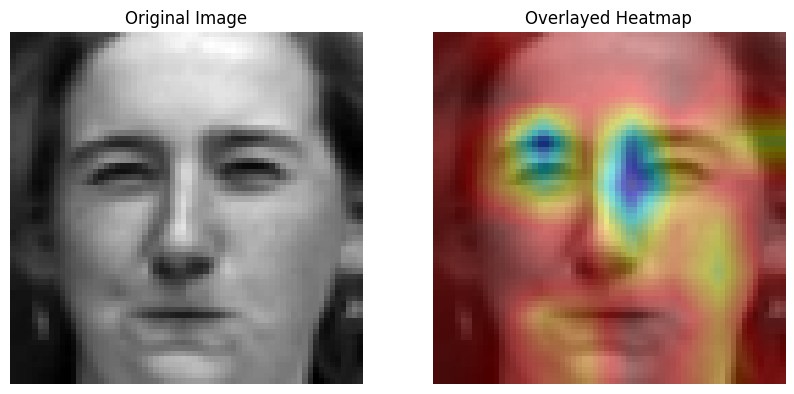

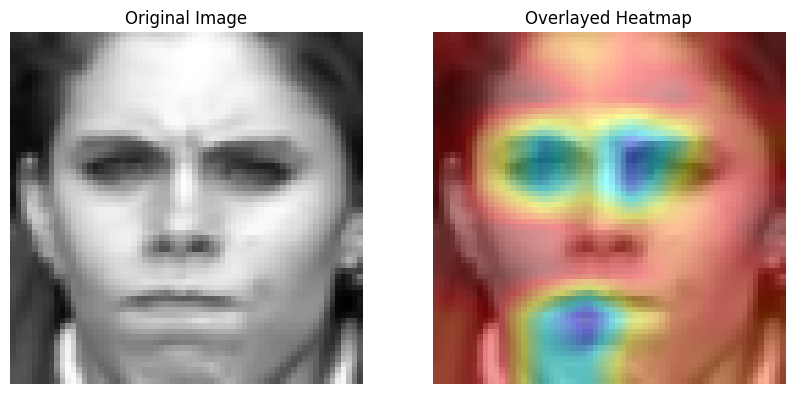

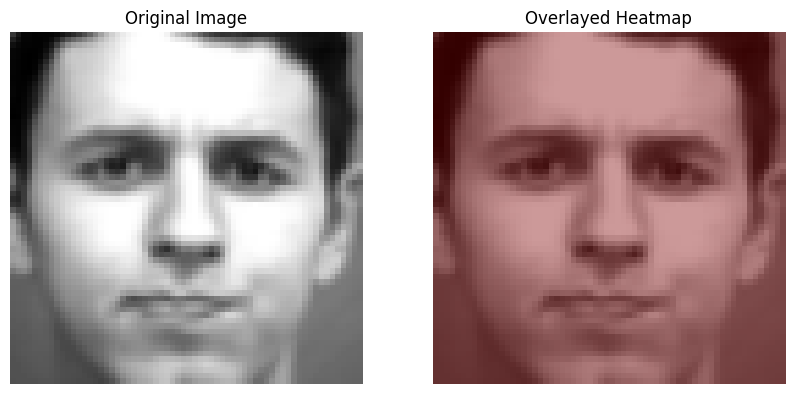

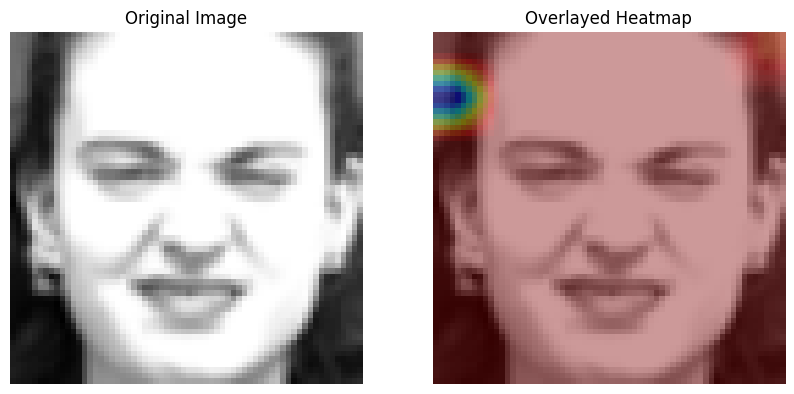

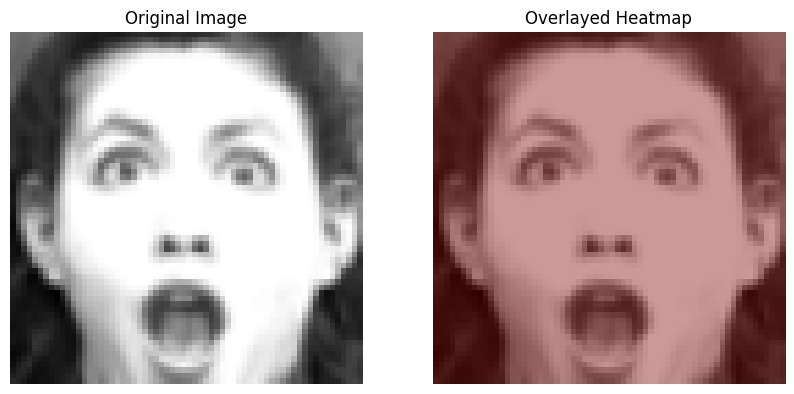

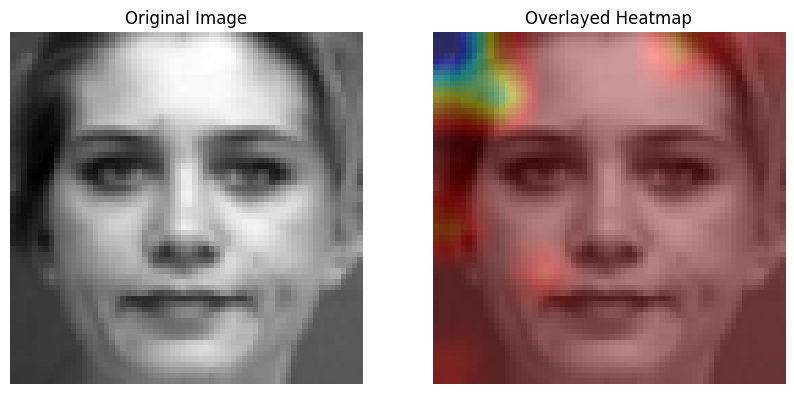

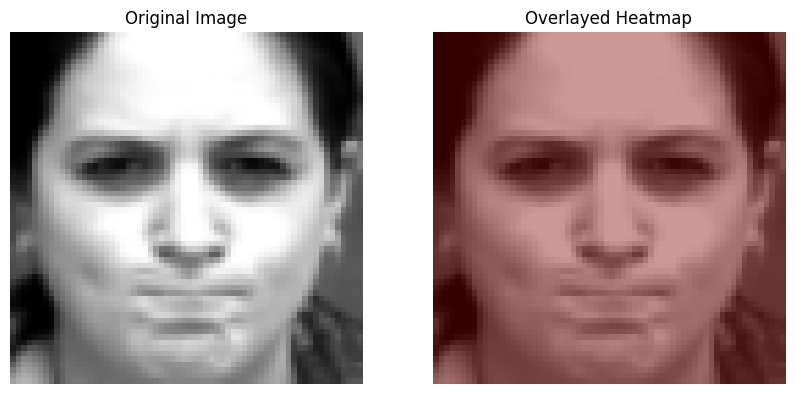

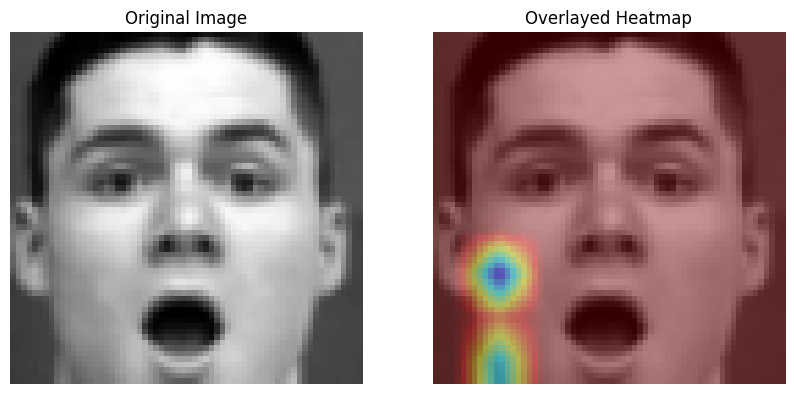

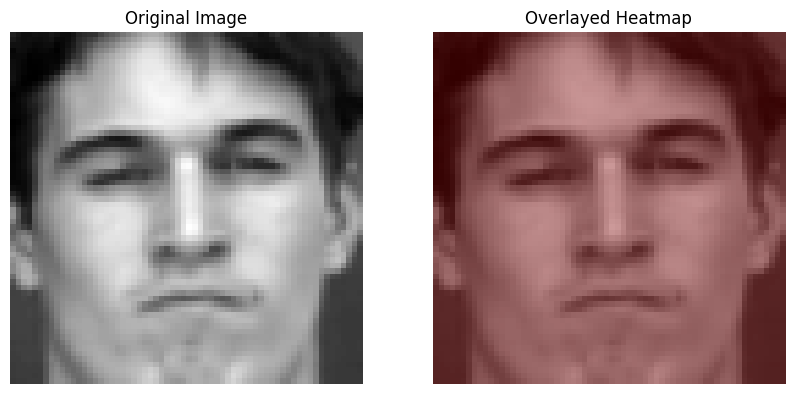

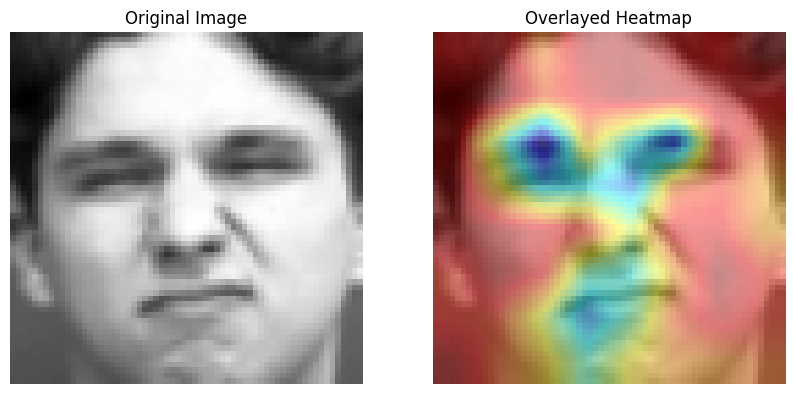

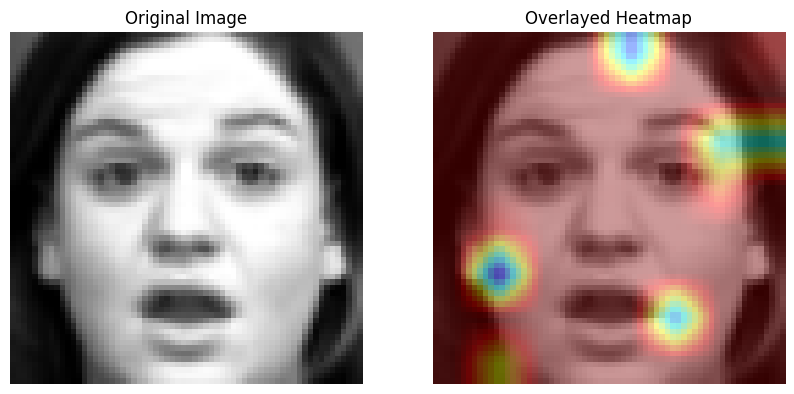

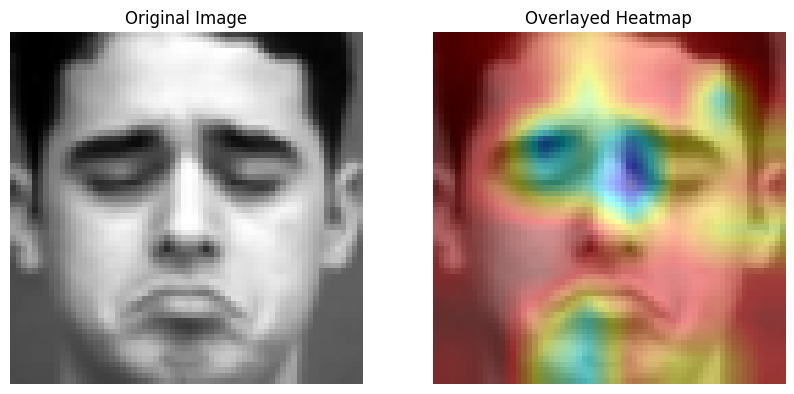

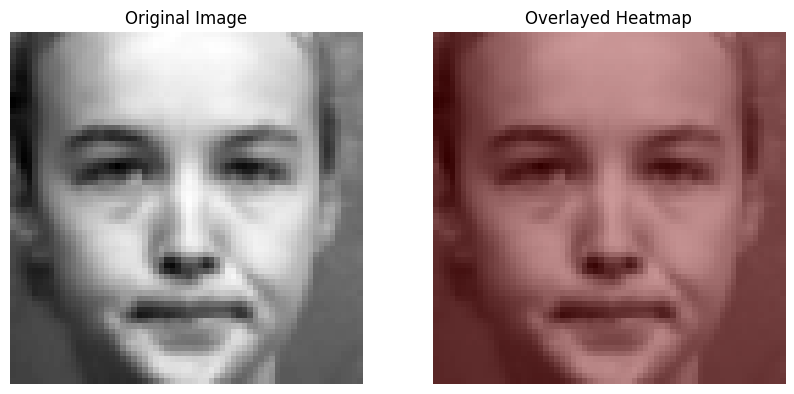

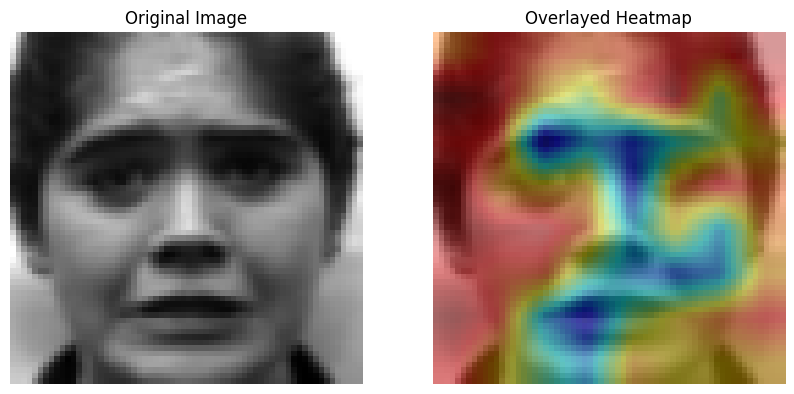

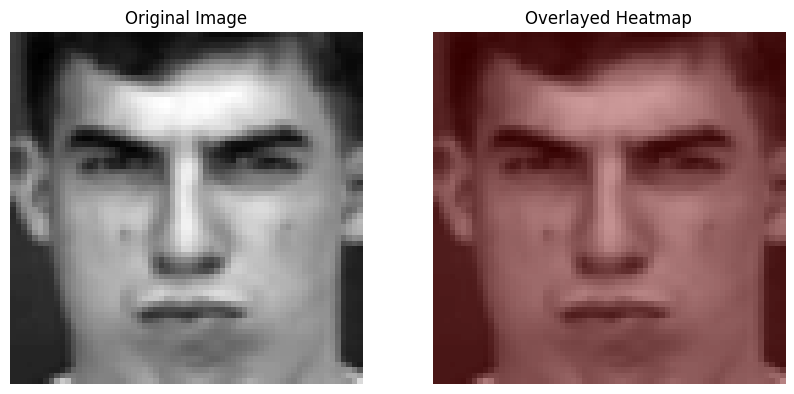

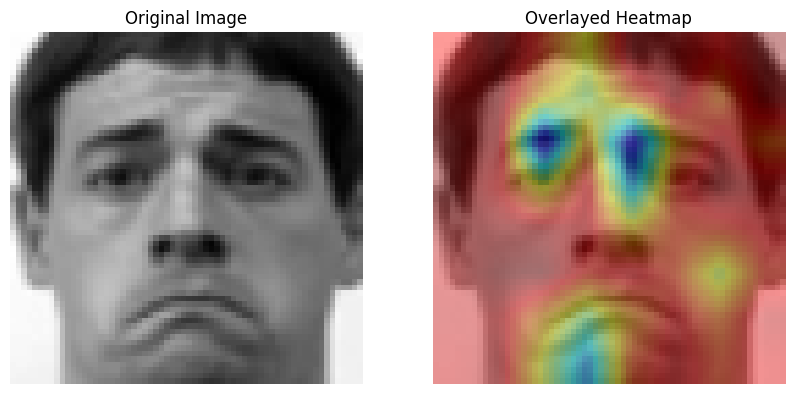

In [6]:
for i in range(16):
    # Clear out gradients 
    model.zero_grad()

    # Forward pass
    output = model(test_batch[0][i].unsqueeze(0))
    
    # Perform backward on most likely class logit 
    target_class = torch.argmax(output)
    target_class_logit = output[:, target_class]
    target_class_logit.backward()

    # Compute Grad-CAM
    gradients = model.gradients[0].unsqueeze(0)  # Extract gradients
    features = model.features  # Extract feature maps
    weights = gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
    cam = (weights * features).sum(dim=1).squeeze(0)  # Weighted combination
    cam = F.relu(cam)  # ReLU to focus on positive regions

    # Normalize the heatmap
    heatmap = cam.detach().cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # Normalize to [0, 1]
    heatmap_resized = cv2.resize(heatmap, (64, 64))  # Resize to match input size
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale to [0, 255]

    # Apply colormap (JET)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Convert the grayscale image to RGB for overlay
    grayscale_image = test_batch[0][i][0].cpu().numpy()
    grayscale_image_normalized = (grayscale_image - grayscale_image.min()) / (grayscale_image.max() - grayscale_image.min() + 1e-8)
    grayscale_image_rgb = cv2.cvtColor((grayscale_image_normalized * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Overlay the heatmap on the grayscale image
    overlay = cv2.addWeighted(grayscale_image_rgb, 0.6, heatmap_colored, 0.4, 0)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(grayscale_image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Overlayed Heatmap")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


In [4]:
def ViT_CAM(batch, model=None, target_class=None, vis_target_class=False, device='cuda:2'):

    # Set up model 
    model.eval()

    # Set up image and CAM lists
    images = []
    cams = []

    # Compute CAM for all images in batch
    for idx, image in enumerate(batch[0]): 

        # Set up model
        model.zero_grad()

        # Forward 
        classification_output = model(image.unsqueeze(0).to(device))

        # Backward Model
        target_class = torch.argmax(classification_output)
        target_class_logit = classification_output[:, target_class]
        target_class_logit.backward(retain_graph=True)
        gradients = [block.attn.gradients[:,:,0,:] for block in model.attention_module]

        # Generate attention maps
        attention_maps = [block.attn.attention_scores for block in model.attention_module]
        cls_attention_maps = [attention_map[:, :, 0, :] for attention_map in attention_maps]
        sigmoid = nn.Sigmoid()
        feature_maps = [sigmoid(cls_attention) for cls_attention in cls_attention_maps]

        cam = 0
        for layer_index in range(len(attention_maps)):
            for head_index in range(attention_maps[0].shape[1]):
                features = feature_maps[layer_index][:, head_index, :]
                grad = F.relu(gradients[layer_index][:, head_index, :])

                cam += features * grad
        cam = cam[:, 1:].reshape(16,16).unsqueeze(0).unsqueeze(0)
        cam = F.interpolate(cam, size=(64,64), mode='bilinear').squeeze()

        images.append(image[0])        
        cams.append(cam.cpu().detach().numpy())
    return images, cams

16


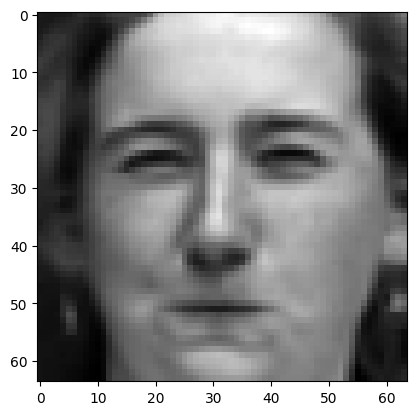

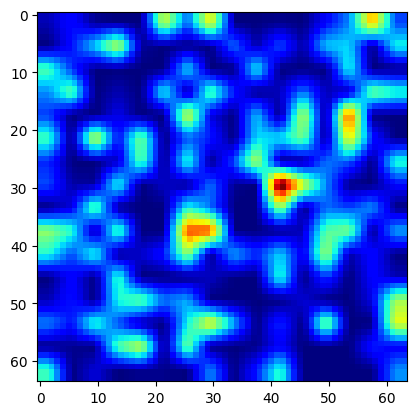

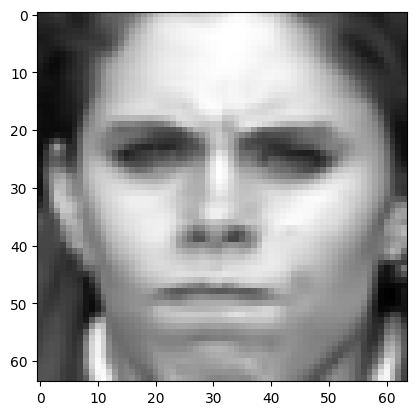

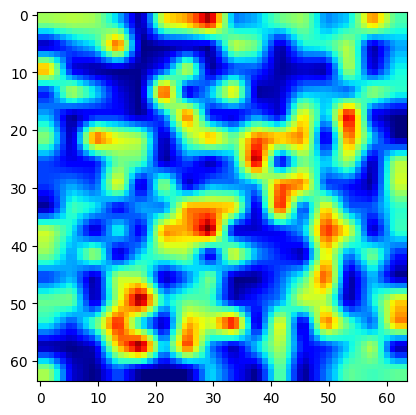

In [5]:
output = ViT_CAM(batch=test_batch, model=model,device='cpu')
print(len(output[1]))
for i in range(2):
    plt.imshow(output[0][i], cmap='gray', )
    plt.show()
    plt.imshow(output[1][i], cmap='jet')
    plt.show()